In [1]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata

import matplotlib.pyplot as plt
import numpy as np
import os

OUTPUT_DIR = "output"



## Load Images

In [2]:
fixed_image = sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32)

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha


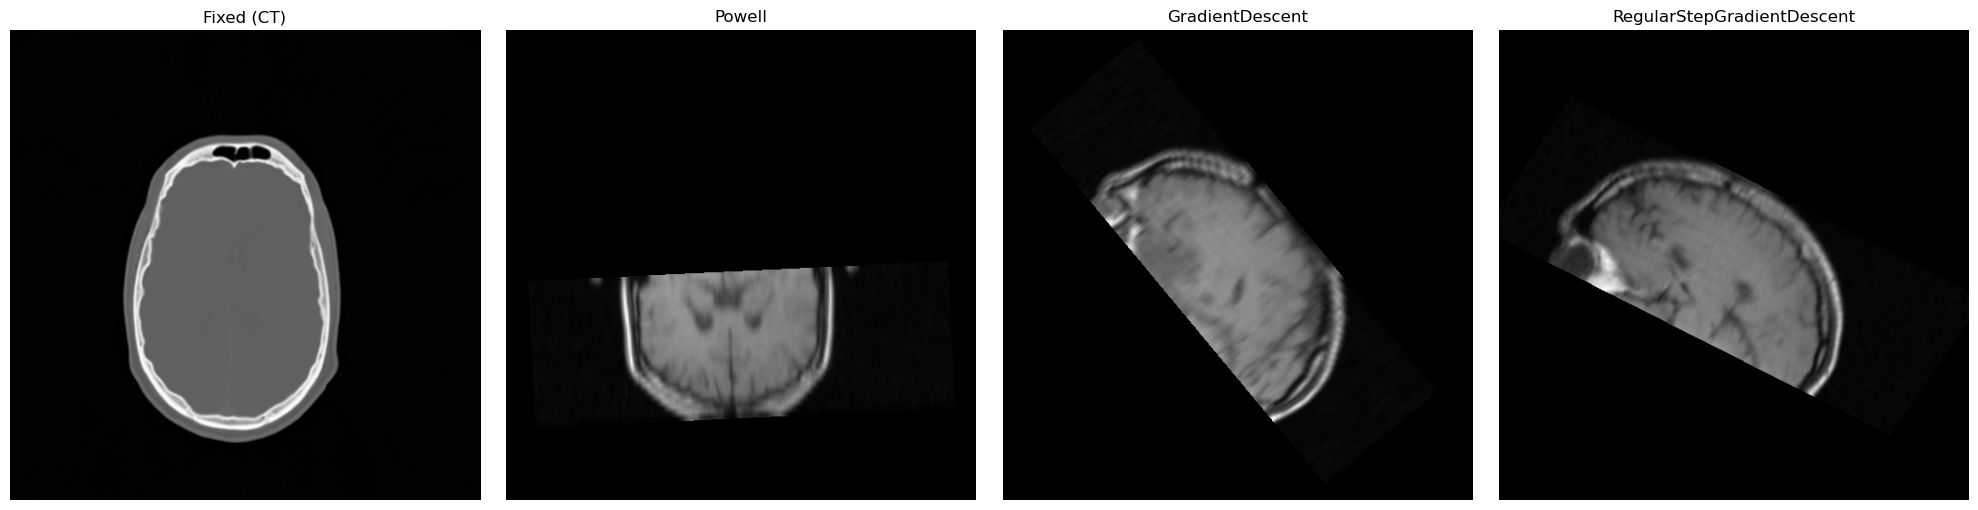

In [ ]:
np_fixed_image = sitk.GetArrayFromImage(fixed_image)
np_moving_image = sitk.GetArrayFromImage(moving_image)

slice_index = np_fixed_image.shape[0] // 2

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np_fixed_image[slice_index, :, :], cmap='gray')
axs[0].set_title("Fixed Image (CT)")
axs[0].axis('off')

axs[1].imshow(np_moving_image[slice_index, :, :], cmap='gray')
axs[1].set_title("Moving Image (MRI)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Initial Transform



In [4]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

In [5]:
registration_method = sitk.ImageRegistrationMethod()

# Metric: Mutual Information

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=1000,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

## Simpan Metric Value

In [8]:
registration_method.SetInitialTransform(initial_transform, inPlace=False)

metric_values = []

def get_metric():
    metric_values.append(registration_method.GetMetricValue())
    
registration_method.AddCommand(sitk.sitkIterationEvent, get_metric)


0

In [9]:
final_transform = registration_method.Execute(fixed_image, moving_image)

print("Final metric value: ", registration_method.GetMetricValue())
print(registration_method.GetOptimizerStopConditionDescription())

plt.plot(metric_values)
plt.title("Mutual Information (MI) over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Metric Value")
plt.grid(True)
plt.show

## simpan registered image 

In [22]:
registered_image = sitk.Resample(
    moving_image, fixed_image, final_transform,
    sitk.sitkLinear, 0.0, moving_image.GetPixelID()
)

np_registered = sitk.GetArrayFromImage(registered_image)

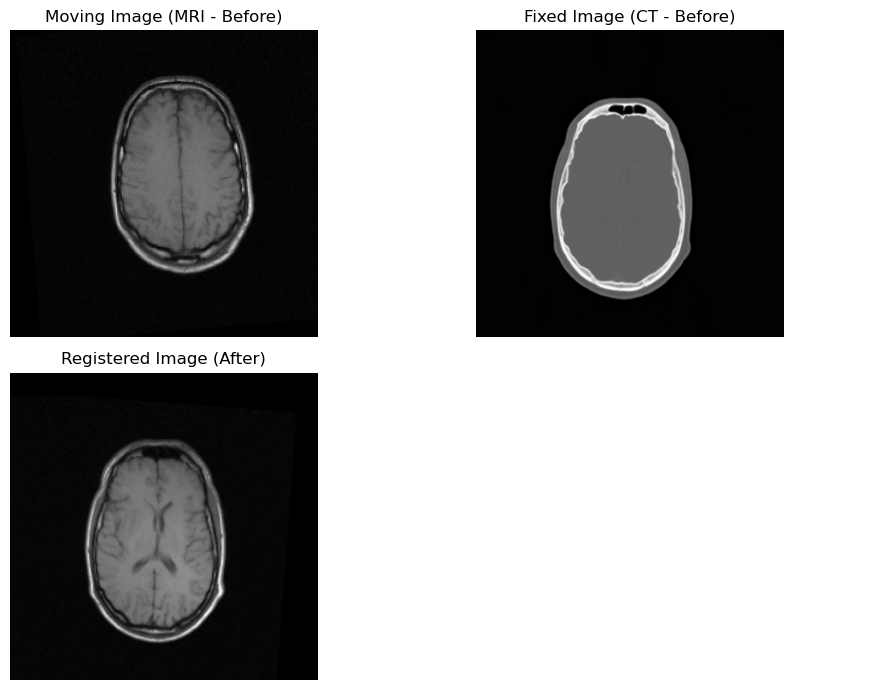

In [26]:
# --- Tampilkan berdampingan: BEFORE & AFTER ---
ig, axs = plt.subplots(2, 2, figsize=(10, 7))

axs[0, 0].imshow(np_moving_image[slice_index, :, :], cmap='gray')
axs[0, 0].set_title("Moving Image (MRI - Before)")

axs[0, 1].imshow(np_fixed_image[slice_index, :, :], cmap='gray')
axs[0, 1].set_title("Fixed Image (CT - Before)")

axs[1, 0].imshow(np_registered[slice_index, :, :], cmap='gray')
axs[1, 0].set_title("Registered Image (After)")

axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()